## C2HO Meetup on Creative Machine Learning

### Convolutional Autoencoder

author: Stefano Fasciani, stefano.fasciani@imv.uio.no

credits: part of this code is adapted from the MNIST examples in Tensorflow and from https://blog.keras.io/building-autoencoders-in-keras.html

commented lines include simple parameters that can be changed to explore creative uses of the model 

__________

#### Importing required packages

In [1]:
import sys
import os
import glob
import imageio
from natsort import natsorted 
import tensorflow as tf
import keras
from keras import layers
from keras.datasets import mnist, cifar10, fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

2023-04-18 07:11:56.782938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Defining the autoencoder model

In this example use use the MNIST (Modified National Institute of Standards and Technology) database of handwritten digits, which are 28 x 28 pixels grayscale images (i.e. each image as an input to the model contains 784 numbers).

Besides building the whole autoencode, we also "assemble" the encoder and decoder, so that we can access (feed and get) intermediate data in the latent space.

In [14]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

encoder = keras.Model(input_img, encoded)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = keras.Model(encoded, decoded)

autoencoder = keras.Model(input_img, decoded)

print(autoencoder.summary(), '\n\n\n')
print(encoder.summary(), '\n\n\n')
print(decoder.summary(), '\n\n\n')

opt = keras.optimizers.Adam(learning_rate = 0.01) 
#opt = keras.optimizers.SGD(learning_rate = 1, momentum=0) # change the learning rate

autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          9248

#### Loading the dataset

The dataset is included in the keras/tensorflow package.
The dataset is already split in training and testing part.
In grayscale images each pixel has a value (integer) between 0 and 255, here we convert to a unitary float range between 0.0 and 1.0.


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('dataset image size and format', x_train[0].shape)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print('number of image in the training set and number of pixels in each image', x_train.shape)
print('number of image in the training set and number of pixels in each image', x_test.shape)

# for using a different dataset, comment the above block of code and uncomment one of the blocks below
# the cifar10 images are slightly bigger and RGB (color), but resized to 28x20 grayscale
# to work with color image we need to modify the model and most of the lines of code where using reshape()

# (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# print('dataset image size and format', x_train[0].shape)
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
# x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
# print('number of image in the training set and number of pixels in each image', x_train.shape)
# print('number of image in the training set and number of pixels in each image', x_test.shape)

# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# print('dataset image size and format', x_train[0].shape)
# x_train = tf.image.rgb_to_grayscale(x_train)
# x_train = tf.image.resize(x_train, [28,28])
# x_train = x_train.numpy()
# x_test = tf.image.rgb_to_grayscale(x_test)
# x_test = tf.image.resize(x_test, [28,28])
# x_test = x_test.numpy()
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
# x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
# print('number of image in the training set and number of pixels in each image', x_train.shape)
# print('number of image in the training set and number of pixels in each image', x_test.shape)

dataset image size and format (28, 28)
number of image in the training set and number of pixels in each image (60000, 28, 28, 1)
number of image in the training set and number of pixels in each image (10000, 28, 28, 1)


#### Training the model

In [4]:
autoencoder.fit(x_train, x_train,
                epochs=2, # this determines how many time we "show" the entire dataset to the model
                batch_size=128,
                shuffle=True,
                verbose=True, # change this to false if you do not want to see epoch progress prints
                validation_data=(x_test, x_test))

Epoch 1/2
469/469 [==============================] - 46s 97ms/step - loss: 0.0948 - val_loss: 0.0728
Epoch 2/2
469/469 [==============================] - 48s 101ms/step - loss: 0.0719 - val_loss: 0.0697


#### Testing the encoder part 1

Here we try the encoder with hand written digit images not used for training.

first row autoencoder input, second row associated autoencoder output


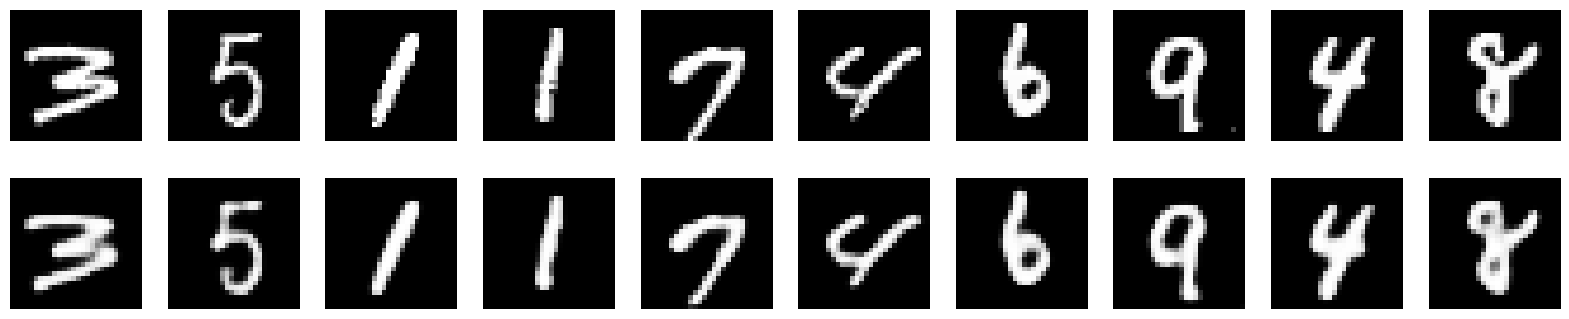

In [5]:
n = 10  # How many digits we will display from the test set

np.random.shuffle(x_test)
encoded_imgs = encoder.predict(x_test, verbose=False)
decoded_imgs = decoder.predict(encoded_imgs, verbose=False)

print('first row autoencoder input, second row associated autoencoder output')

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    # Display reconstruction
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
plt.show()

#### Testing the encoder part 2

Here we try the encoder with hand written digit images not used for training after adding some noise to the image.

first row autoencoder input, second row associated autoencoder output


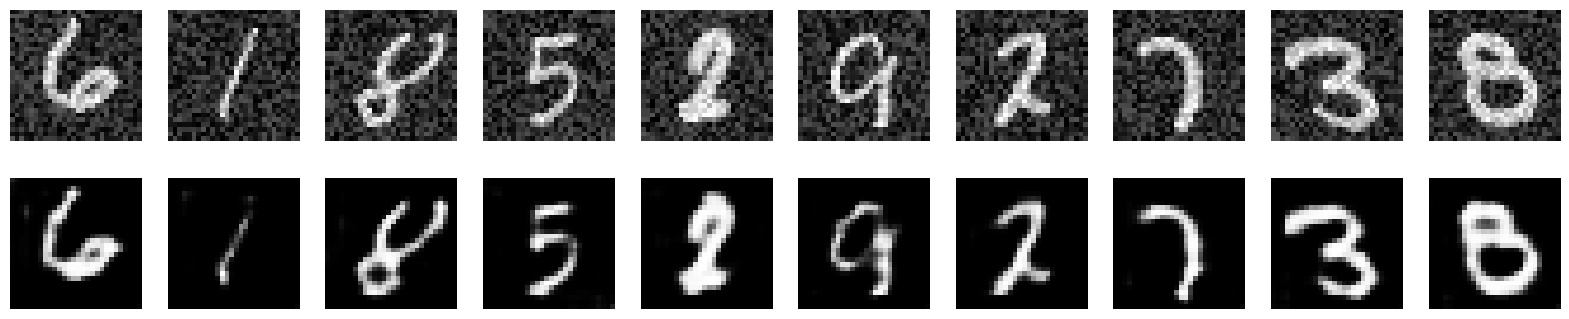

In [6]:
n = 10  # How many digits we will display from the test set

np.random.shuffle(x_test)
x_test_noisy = x_test + (np.random.random(x_test.shape) - 0.5) * 0.5

encoded_imgs = encoder.predict(x_test_noisy, verbose=False)
decoded_imgs = decoder.predict(encoded_imgs, verbose=False)

print('first row autoencoder input, second row associated autoencoder output')

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    # Display reconstruction
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
plt.show()

#### Testing the encoder part 3

Here we try the encoder with hand written digit images not used for training after corrupting some of the pixels (setting to 0 which corresponds to black).

first row autoencoder input, second row associated autoencoder output


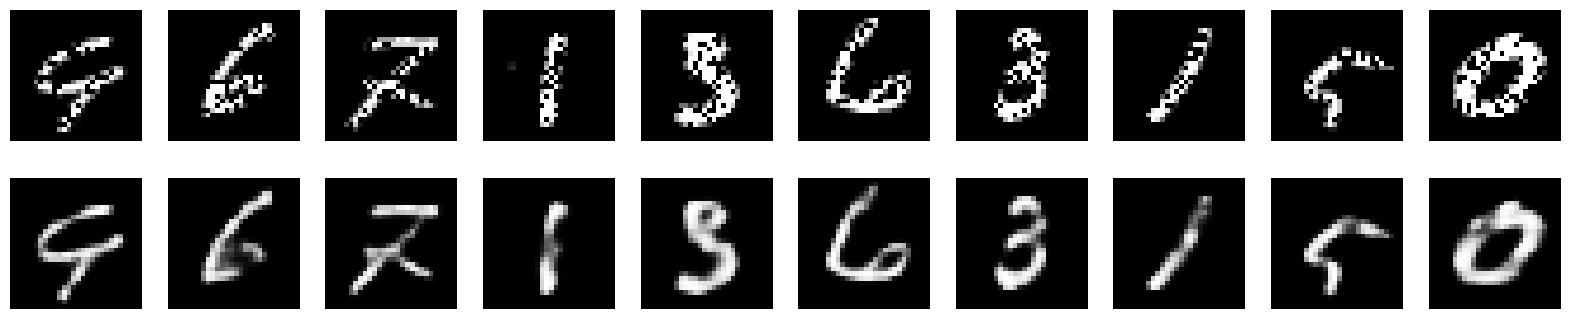

In [7]:
n = 10  # How many digits we will display from the test set

np.random.shuffle(x_test)
x_test_corrupted = x_test * np.round((np.random.random(size=x_test.shape) + 0.2))

encoded_imgs = encoder.predict(x_test_corrupted, verbose=False)
decoded_imgs = decoder.predict(encoded_imgs, verbose=False)

print('first row autoencoder input, second row associated autoencoder output')

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test_corrupted[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    # Display reconstruction
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
plt.show()

#### Feeding the decoder with arbitrary numbers to generate visual patterns

We generate a set of random numbers matching the input of the decoder (i.e. the size fo the latent space) and we display the image generated at the output of the decoder. The random numbers are generated between 0 and 1, then we apply a scaling and offset factors. Mind that we should match aim for values to not too far from the latent space range (displayed below).

In [8]:
encoded_imgs = encoder.predict(x_train, verbose=False)
print('latent space min, max, mean values',np.min(encoded_imgs),np.max(encoded_imgs),np.mean(encoded_imgs))

latent space min, max, mean values 0.0 4.5000696 0.26085332


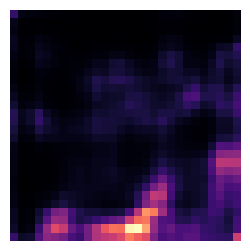

In [9]:
scale = 0.2 # change the scaling factor (positive flot numbers)
offset = 0 # change the offset factor (positive or negative flot numbers)

rnd = (np.random.rand(1, 7, 7, 32) + offset) * scale

decoded_img = decoder.predict(rnd, verbose=False)
                               
plt.figure(figsize=(3, 3))
plt.imshow(decoded_img.reshape(28, 28), cmap='magma') # change the colormal to 'inferno', 'jet', or 'plasma'
plt.axis('off')
plt.show()

#### Feeding the decoder with a sequence of arbitrary numbers to generate a sequence of visual patterns

Here we do the same as above but repeating the generation for n number of times (ufing a for loop). The generated images are displayed all at once, row by row (left to right, top to bottom).

Things that we can try:
* generate a fixed random number outside the loop and update scale/offset with the loop index.
* generate a fixed random number outside the loop and  scale/offset with the loop index'.
* integrate the training in the loop, completing one epoch at each iteration (set a slow n, this will be slow, or use a very small subset of the training set). This can be combined with an increase in the learning rate (to make the model potentially unstable and never converge).
* try with another dataset.
* ...


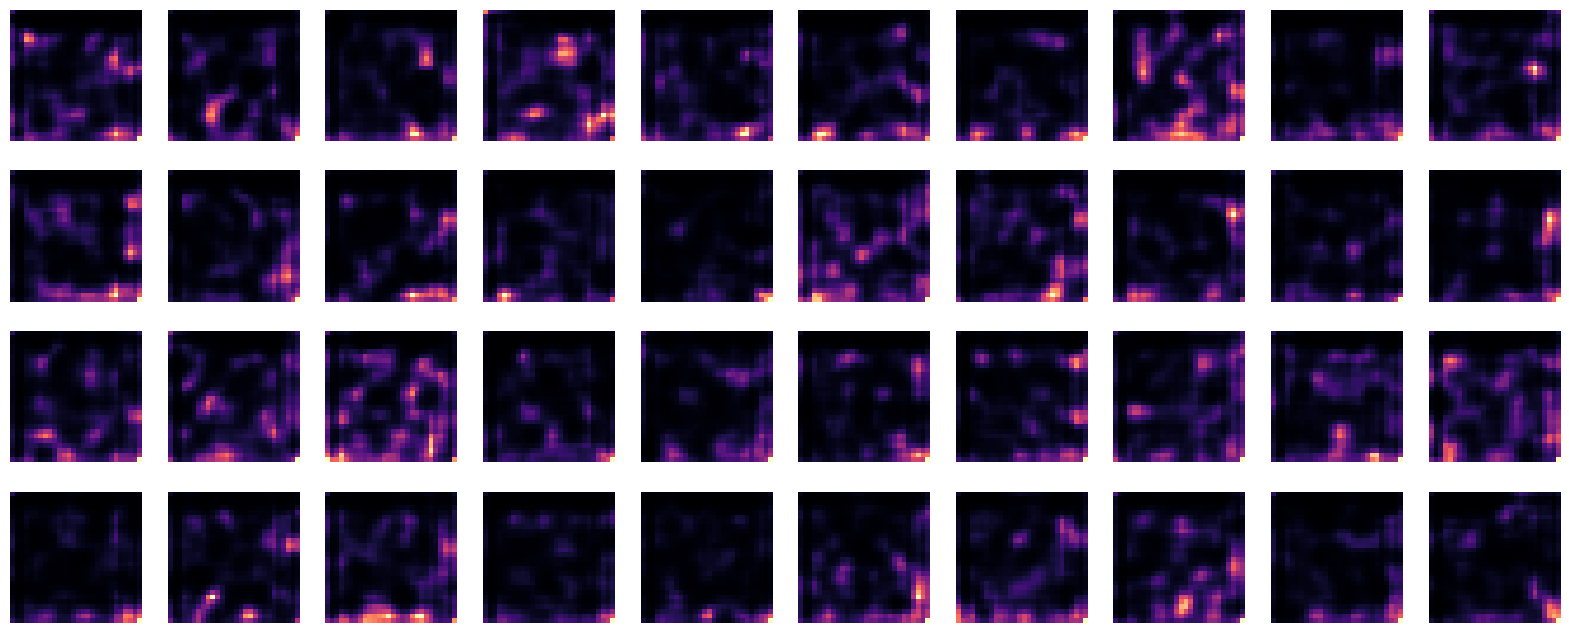

In [10]:
n = 40  # How many digits we will display (must be a multiple of 10)

if n % 10 != 0:
    sys.exit("use n integer multiple of 10")

rows = int(n / 10)
cols = int(n / rows)

plt.figure(figsize=(20, 2*rows))


for i in range(n):
    
    scale = 0.2 # change the scaling factor (positive flot numbers)
    offset = 0 # change the offset factor (positive or negative flot numbers)
    rnd = (np.random.rand(1, 7, 7, 32) + offset) * scale
    
    #temp = rnd * i/n
    #rnd = 0.8*(rnd) + 0.2*(np.random.rand(1, encoding_dim))*scale
    
    decoded_img = decoder.predict(rnd, verbose=False)
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(decoded_img.reshape(28, 28), cmap='magma')
    plt.axis('off')

#### Feeding the decoder with a sequence of arbitrary numbers to generate an animated GIF of visual patterns

Same concept as above, but here we save the sequence of images in an animated GIF (out.gif)


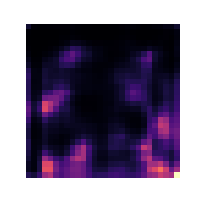

In [12]:
n = 40  # How many digits we will display generate and sequence in a gif

tempdir = './temp'
if os.path.isdir(tempdir):
    for f in os.listdir(tempdir):
        os.remove(os.path.join(tempdir, f))
    os.rmdir(tempdir)

os.makedirs(tempdir)

for i in range(n):
    
    scale = 0.2 # change the scaling factor (positive flot numbers)
    offset = 0 # change the offset factor (positive or negative flot numbers)
    rnd = (np.random.rand(1, 7, 7, 32) + offset) * scale
    
    #temp = rnd * i/n
    #rnd = 0.8*(rnd) + 0.2*(np.random.rand(1, encoding_dim))*scale
    
    decoded_img = decoder.predict(rnd, verbose=False)
    plt.figure(figsize=(2, 2)) # change to a bigger or smaller gif (but original image resolution will stay 28x28)
    plt.imshow(decoded_img.reshape(28, 28), cmap='magma')
    plt.axis('off')
    plt.savefig(tempdir+'/image'+str(i)+'.png')
    plt.close()

gif_file = 'out.gif'

with imageio.get_writer(gif_file, mode='I') as writer:
    filenames = glob.glob(tempdir+'/image*'+'.png')
    filenames = natsorted(filenames)
    for filename in filenames:
        image = imageio.v3.imread(filename)
        writer.append_data(image)
        
import tensorflow_docs.vis.embed as embed
embed.embed_file(gif_file)

#### Training the autoencoder with different input-output pairs 

Instead of training the autoencoder with the same image for input and output, create consistent input output pairs generating the same dataset. This code use the known labels of the digits to create consistent arrays of input output pairs. For example, when the input is a 0 the model will learn to generate a 5, when the input is 1, the model will learn to generate a 6, and so on.


In [13]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('dataset image size and format', x_train[0].shape)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print('number of image in the training set and number of pixels in each image', x_train.shape)
print('number of image in the training set and number of pixels in each image', x_test.shape)

digits_per_class_train = 5000 
digits_per_class_test = 800

x_train_in = np.empty([0,x_train.shape[1],x_train.shape[2],x_train.shape[3]])
x_train_out = np.empty([0,x_train.shape[1],x_train.shape[2],x_train.shape[3]])
x_test_in = np.empty([0,x_train.shape[1],x_train.shape[2],x_train.shape[3]])
x_test_out = np.empty([0,x_train.shape[1],x_train.shape[2],x_train.shape[3]])

print(x_train.shape)
print(x_train_in.shape)

in_digits = [7, 0, 6, 5, 3] # change the contents of these arrays but each must include 5 numbers
out_digits = [2, 9, 4, 8, 1]

for i in range(5):

    idx_in_train = np.where((y_train == in_digits[i]))[0]
    idx_out_train = np.where((y_train == out_digits[i]))[0]
    idx_in_test = np.where((y_test == in_digits[i]))[0]    
    idx_out_test = np.where((y_test == out_digits[i]))[0]

    x_train_in = np.vstack([x_train_in, x_train[idx_in_train[0:digits_per_class_train],:]])
    x_train_out = np.vstack([x_train_out, x_train[idx_out_train[0:digits_per_class_train],:]])
    x_test_in = np.vstack([x_test_in, x_test[idx_in_test[0:digits_per_class_test],:]])
    x_test_out = np.vstack([x_test_out, x_test[idx_out_test[0:digits_per_class_test],:]])

print('number of image in the input training set and number of pixels in each image',x_train_in.shape)
print('number of image in the output training set and number of pixels in each image',x_train_out.shape)
print('number of image in the input test set and number of pixels in each image',x_test_in.shape)
print('number of image in the output test set and number of pixels in each image',x_test_out.shape)

dataset image size and format (28, 28)
number of image in the training set and number of pixels in each image (60000, 28, 28, 1)
number of image in the training set and number of pixels in each image (10000, 28, 28, 1)
(60000, 28, 28, 1)
(0, 28, 28, 1)
number of image in the input training set and number of pixels in each image (25000, 28, 28, 1)
number of image in the output training set and number of pixels in each image (25000, 28, 28, 1)
number of image in the input test set and number of pixels in each image (4000, 28, 28, 1)
number of image in the output test set and number of pixels in each image (4000, 28, 28, 1)


Before running the following cell, we have to re-initialize (i.e. reset the weights to random number) by running the cell "Defining the autoencoder model".

In [15]:
autoencoder.fit(x_train_in, x_train_out,
                epochs=2, # this determines how many time we "show" the entire dataset to the model
                batch_size=128,
                shuffle=True,
                verbose=True, # change this to false if you do not want to see epoch progress prints
                validation_data=(x_test_in, x_test_out))

Epoch 1/2
196/196 [==============================] - 21s 106ms/step - loss: 0.2760 - val_loss: 0.2373
Epoch 2/2
196/196 [==============================] - 20s 102ms/step - loss: 0.2390 - val_loss: 0.2287


Then we can verify if the model has effectively learned to convert images across specific pairs of digits.

first row autoencoder input, second row associated autoencoder output


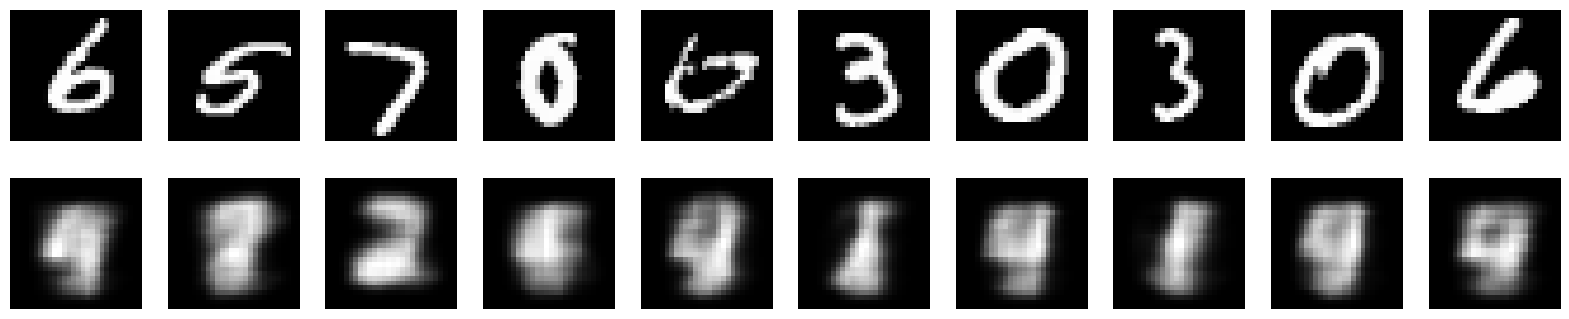

In [16]:
n = 10  # How many digits we will display from the test set

rnd_indexes = np.arange(len(x_test_in))
np.random.shuffle(rnd_indexes)
x_test_in = x_test_in[rnd_indexes]
x_test_out = x_test_out[rnd_indexes]

encoded_imgs = encoder.predict(x_test_in, verbose=False)
decoded_imgs = decoder.predict(encoded_imgs, verbose=False)

print('first row autoencoder input, second row associated autoencoder output')

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test_in[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    # Display reconstruction
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
plt.show()